## 1. 准备环境与导入库

In [1]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import json
import math
import random
import re
from collections import Counter
from typing import List, Tuple, Dict

import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report
import numpy as np

# 2. 设置随机种子 ———— 42 
# 保证可复现性
def set_seed(seed: int = 42) -> None:
    random.seed(seed)                          # Python 内置随机库
    torch.manual_seed(seed)                    # PyTorch CPU 随机种子
    torch.cuda.manual_seed_all(seed)           # PyTorch GPU (CUDA) 随机种子（如果有）
    np.random.seed(seed)                       # Numpy 随机种子
    # 注意：MPS 目前没有完全统一的 manual_seed 接口，但在 CPU/CUDA 上这步是标准的。

# 3. 选择计算设备 (Device Selection)
force_mps = True
if force_mps and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: mps (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: cuda")
else:
    device = torch.device("cpu")
    print("Using device: cpu")

set_seed(42)

Using device: mps (Apple Silicon)


## 2. 读取数据与探索性分析 (EDA)

样本总数: 209527
Loading GloVe vectors from DATA/glove.6B.100d.txt...
⚠️ Error: GloVe file not found at DATA/glove.6B.100d.txt.
Please download it from https://nlp.stanford.edu/data/glove.6B.zip

==================== 数据画像 ====================
缺失值统计:
headline             0
category             0
short_description    0
authors              0
dtype: int64

类别分布 (Top 5):
category
Politics & World Affairs    53567
Arts & Entertainment        44473
Lifestyle & Leisure         37611
Health & Wellness           24639
Society & Identity          18209
Name: count, dtype: int64

文本长度统计 (Headline & Description):
       headline_len  desc_len
count      209527.0  209527.0
mean           58.4     114.2
std            18.8      80.8
min             0.0       0.0
25%            46.0      59.0
50%            60.0     120.0
75%            71.0     134.0
max           320.0    1472.0


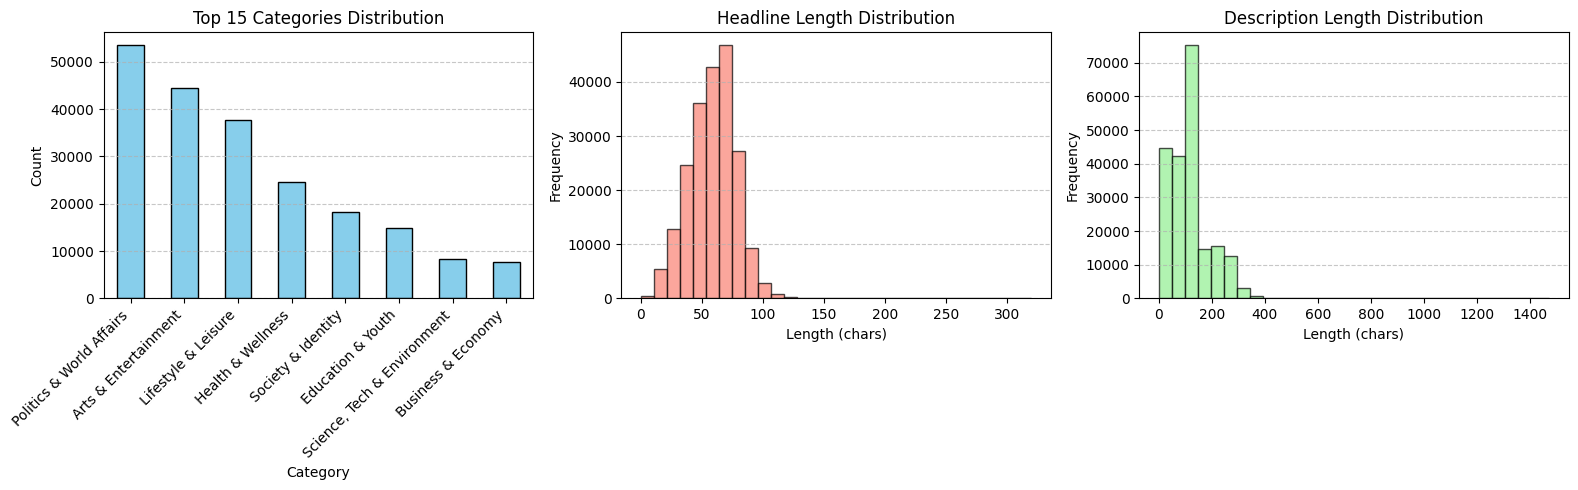


==================== 数据样例 ====================

[Index 128310] Category: Politics & World Affairs
Headline: What If We Were All Family Generation Changers?
Description: What if, in doing so, we won't just create new opportunities for ourselves, we'll also uncover ways to create new opportunities for our families that may not have otherwise existed?

[Index 139983] Category: Business & Economy
Headline: Firestorm At AOL Over Employee Benefit Cuts
Description: It should have been a glorious week for AOL chief executive Tim Armstrong. His company’s quarterly earnings, announced Thursday

[Index 42339] Category: Politics & World Affairs
Headline: Dakota Access Protesters Arrested As Deadline Passes To Depart Camp
Description: A few protesters who refused to leave remained at the site Thursday.


In [2]:
# 1. 读取数据文件
data_path = "../DATA/dataset.json"
with open(data_path, "r", encoding="utf-8") as f:
    records = json.load(f)

print(f"样本总数: {len(records)}")

# 2. 加载 GloVe 词向量函数
def load_glove_vectors(glove_file: str, embedding_dim: int = 100) -> Dict[str, np.ndarray]:
    print(f"Loading GloVe vectors from {glove_file}...")
    embeddings_index = {}
    try:
        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Found {len(embeddings_index)} word vectors.")
    except FileNotFoundError:
        print(f"⚠️ Error: GloVe file not found at {glove_file}.")
        print("Please download it from https://nlp.stanford.edu/data/glove.6B.zip")
        return {}
    return embeddings_index

# 定义 GloVe 文件路径 (请确保文件存在!)
glove_path = "DATA/glove.6B.100d.txt"
glove_vectors = load_glove_vectors(glove_path, embedding_dim=100)

# 3. 数据画像 (Data Profiling)
df = pd.DataFrame(records)

print("\n" + "="*20 + " 数据画像 " + "="*20)
# 检查缺失值
print(f"缺失值统计:\n{df.isnull().sum()}")

# 类别分布
print("\n类别分布 (Top 5):")
category_counts = df['category'].value_counts()
print(category_counts.head(5))

# 文本长度统计
df['headline_len'] = df['headline'].fillna("").apply(len)
df['desc_len'] = df['short_description'].fillna("").apply(len)

print("\n文本长度统计 (Headline & Description):")
print(df[['headline_len', 'desc_len']].describe().round(1))

# --- 可视化展示 ---
plt.figure(figsize=(16, 5))

# 图1: 类别分布 (Top 15)
plt.subplot(1, 3, 1)
category_counts.head(15).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 15 Categories Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 图2: Headline 长度分布
plt.subplot(1, 3, 2)
plt.hist(df['headline_len'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.title("Headline Length Distribution")
plt.xlabel("Length (chars)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 图3: Description 长度分布
plt.subplot(1, 3, 3)
plt.hist(df['desc_len'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title("Description Length Distribution")
plt.xlabel("Length (chars)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4. 展示样例数据
print("\n" + "="*20 + " 数据样例 " + "="*20)
samples = df.sample(3)
for idx, row in samples.iterrows():
    print(f"\n[Index {idx}] Category: {row['category']}")
    print(f"Headline: {row['headline']}")
    print(f"Description: {row['short_description']}")

## 3. 第一、二个训练模型

### 1.数据处理与模型构建

In [3]:
# --- 自定义分词器 (Tokenizer) ---
class WhitespaceTokenizer:
    def __init__(self, max_vocab_size: int = 30000, min_freq: int = 2, max_length: int = 64):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.max_length = max_length
        self.pad_token = "<pad>"
        self.unk_token = "<unk>"
        self.cls_token = "<cls>"
        self.token_to_id = {self.pad_token: 0, self.unk_token: 1, self.cls_token: 2}
        self.id_to_token = {0: self.pad_token, 1: self.unk_token, 2: self.cls_token}

    def tokenize(self, text: str) -> List[str]:
        text = text.lower().strip()
        return re.findall(r"\w+|[^\w\s]", text)

    def build_vocab(self, texts: List[str]) -> None:
        counter = Counter()
        for t in texts:
            counter.update(self.tokenize(t))
        most_common = [w for w, c in counter.most_common(self.max_vocab_size) if c >= self.min_freq]
        for idx, token in enumerate(most_common, start=len(self.token_to_id)):
            if token not in self.token_to_id:
                self.token_to_id[token] = idx
                self.id_to_token[idx] = token

    def encode(self, text: str) -> Tuple[List[int], List[int]]:
        tokens = [self.cls_token] + self.tokenize(text)
        tokens = tokens[: self.max_length]
        ids = [self.token_to_id.get(tok, self.token_to_id[self.unk_token]) for tok in tokens]
        pad_length = self.max_length - len(ids)
        if pad_length > 0:
            ids += [self.token_to_id[self.pad_token]] * pad_length
        attention_mask = [1 if i != self.token_to_id[self.pad_token] else 0 for i in ids]
        return ids, attention_mask

# --- 自定义数据集 (Dataset) ---
class NewsDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer: WhitespaceTokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        ids, mask = self.tokenizer.encode(self.texts[idx])
        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# --- 位置编码 (Positional Encoding) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, : x.size(1)]

# --- 文本分类模型 (Classifier) ---
# 修改：支持加载预训练 Embedding
class NewsClassifier(nn.Module):
    def __init__(self, vocab_size: int, num_labels: int, d_model: int = 100, num_heads: int = 4, 
                 num_layers: int = 2, dim_feedforward: int = 256, dropout: float = 0.1, 
                 pretrained_embeddings: torch.Tensor = None):
        super().__init__()
        
        # 1. 词嵌入层
        if pretrained_embeddings is not None:
            print("Initializing Embedding layer with GloVe weights...")
            # freeze=False 允许微调 Embedding
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False, padding_idx=0)
            # 确保 d_model 与 GloVe 维度一致
            d_model = pretrained_embeddings.size(1)
        else:
            self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        padding_mask = attention_mask == 0
        x = self.embedding(input_ids) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        cls_repr = x[:, 0, :]
        logits = self.classifier(self.dropout(cls_repr))
        return logits

### 2. 数据处理

In [4]:
# --- 辅助函数：创建 Embedding 矩阵 ---
def create_embedding_matrix(word_index: Dict[str, int], embeddings_index: Dict[str, np.ndarray], embedding_dim: int = 100) -> torch.Tensor:
    vocab_size = len(word_index)
    # 使用正态分布随机初始化，作为未命中词的默认值
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))
    
    hits = 0
    misses = 0
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
            
    print(f"Embedding Matrix created: {hits} hits, {misses} misses. (Coverage: {hits/vocab_size:.1%})")
    return torch.tensor(embedding_matrix, dtype=torch.float32)

# --- 数据准备函数 (GloVe 版) ---
def prepare_datasets_glove(records, tokenizer, glove_vectors, text_key="headline", split_ratios=(0.7, 0.15, 0.15)):
    df = pd.DataFrame(records)
    
    if text_key not in df.columns:
        print(f"Warning: Key '{text_key}' not found in dataset. Using empty strings.")
        texts = [""] * len(df)
    else:
        texts = df[text_key].fillna("").tolist()
        
    labels_raw = df["category"].tolist()

    # Label Mapping
    unique_labels = sorted(set(labels_raw))
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {i: label for label, i in label2id.items()}
    labels = [label2id[l] for l in labels_raw]

    # Build Vocab
    tokenizer.build_vocab(texts)
    
    # Create Embedding Matrix
    embedding_matrix = None
    if glove_vectors:
        embedding_matrix = create_embedding_matrix(tokenizer.token_to_id, glove_vectors, embedding_dim=100)

    # Create Dataset
    dataset = NewsDataset(texts, labels, tokenizer)
    
    # Split
    total_size = len(dataset)
    train_size = int(split_ratios[0] * total_size)
    val_size = int(split_ratios[1] * total_size)
    meta_size = total_size - train_size - val_size
    
    train_ds, val_ds, meta_ds = random_split(
        dataset, [train_size, val_size, meta_size], generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset prepared for key='{text_key}': Train={len(train_ds)}, Val={len(val_ds)}, Meta={len(meta_ds)}, Vocab={len(tokenizer.token_to_id)}")
    return train_ds, val_ds, meta_ds, label2id, id2label, embedding_matrix

# --- 数据批处理函数 ---
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return input_ids, attention_mask, labels

### 3.训练与评估循环


==================== 开始并行训练双流模型 (GloVe) ====================

==================== 开始训练模型: headline ====================

==================== 开始训练模型: short_description ====================
Embedding Matrix created: 29291 hits, 712 misses. (Coverage: 97.6%)
Dataset prepared for key='headline': Train=146668, Val=31429, Meta=31430, Vocab=30003
Class weights calculated (min=0.49, max=3.42)
Initializing Embedding layer with GloVe weights...
Embedding Matrix created: 29549 hits, 454 misses. (Coverage: 98.5%)
Dataset prepared for key='short_description': Train=146668, Val=31429, Meta=31430, Vocab=30003
Class weights calculated (min=0.49, max=3.42)
Initializing Embedding layer with GloVe weights...
[short_description] Epoch 1/50 | Step 50/4584 | loss=2.0268
[headline] Epoch 1/50 | Step 50/4584 | loss=2.1749
[headline] Epoch 1/50 | Step 100/4584 | loss=1.7548
[short_description] Epoch 1/50 | Step 100/4584 | loss=2.0791
[headline] Epoch 1/50 | Step 150/4584 | loss=1.5086
[short_description] Ep

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/transformer.py:467: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  ) and not torch._nested_tensor_from_mask_left_aligned(


                             precision    recall  f1-score   support

       Arts & Entertainment       0.73      0.64      0.68      6642
         Business & Economy       0.43      0.56      0.49      1219
          Education & Youth       0.56      0.72      0.63      2197
          Health & Wellness       0.58      0.78      0.66      3661
        Lifestyle & Leisure       0.75      0.68      0.71      5689
   Politics & World Affairs       0.85      0.63      0.72      8074
Science, Tech & Environment       0.41      0.63      0.49      1266
         Society & Identity       0.48      0.55      0.51      2681

                   accuracy                           0.66     31429
                  macro avg       0.60      0.65      0.61     31429
               weighted avg       0.69      0.66      0.66     31429

[headline] Epoch 1/50: train_loss=1.1962, val_acc=0.6562
                             precision    recall  f1-score   support

       Arts & Entertainment       0.63    

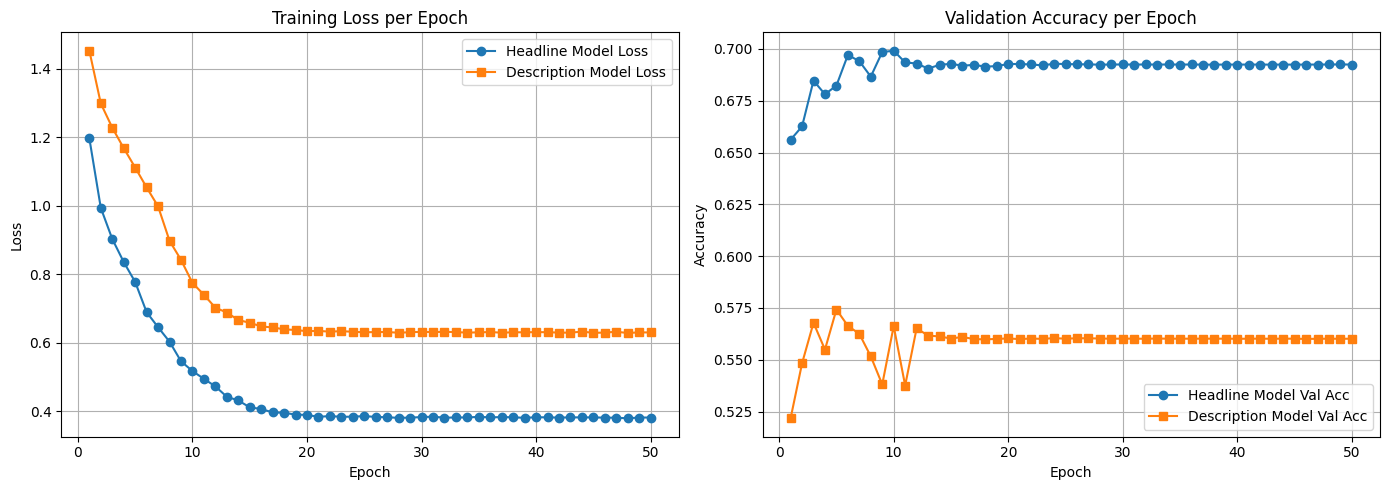

In [ ]:
# --- 核心训练逻辑封装 ---
import time

# 训练函数
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch, num_epochs, prefix="", log_every=2000):
    model.train()
    total_loss = 0.0
    for step, (input_ids, attention_mask, labels) in enumerate(dataloader, start=1):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * input_ids.size(0)
        if step % log_every == 0:
            print(f"[{prefix}] Epoch {epoch}/{num_epochs} | Step {step}/{len(dataloader)} | loss={loss.item():.4f}")
    return total_loss / len(dataloader.dataset)

# 评估函数
def evaluate_detailed(model, dataloader, device, id2label):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    target_names = [id2label[i] for i in range(len(id2label))]
    report = classification_report(all_labels, all_preds, target_names=target_names, zero_division=0)
    print(report)
    
    correct = sum([1 for p, l in zip(all_preds, all_labels) if p == l])
    return correct / len(all_labels)

def run_training_pipeline(text_key, save_name, glove_vectors, num_epochs=2):
    print(f"\n{'='*20} 开始训练模型: {text_key} {'='*20}")
    start_time = time.time()
    
    tokenizer = WhitespaceTokenizer(max_vocab_size=30000, min_freq=2, max_length=64)
    
    # 准备数据 (Train / Val / Meta) - 使用 GloVe
    train_ds, val_ds, meta_ds, label2id, id2label, embedding_matrix = prepare_datasets_glove(
        records, tokenizer, glove_vectors, text_key=text_key
    )
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
    
    # 计算类别权重
    all_labels = [train_ds.dataset.labels[i] for i in train_ds.indices]
    label_counts = Counter(all_labels)
    total_samples = len(all_labels)
    num_classes = len(label2id)
    weights = [total_samples / (num_classes * label_counts.get(i, 1)) for i in range(num_classes)]
    class_weights = torch.FloatTensor(weights).to(device)
    print(f"Class weights calculated (min={min(weights):.2f}, max={max(weights):.2f})")

    # 初始化模型 - 使用 GloVe
    model = NewsClassifier(
        vocab_size=len(tokenizer.token_to_id),
        num_labels=len(label2id),
        d_model=100, # GloVe 维度
        num_heads=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1,
        pretrained_embeddings=embedding_matrix
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    best_val_acc = 0.0
    history = {"train_loss": [], "val_acc": []}
    
    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs, prefix=text_key)
        
        print(f"--- Validation Report Epoch {epoch} ---")
        val_acc = evaluate_detailed(model, val_loader, device, id2label)
        print(f"[{text_key}] Epoch {epoch}/{num_epochs}: train_loss={train_loss:.4f}, val_acc={val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                "model_state_dict": model.state_dict(),
                "label2id": label2id,
                "id2label": id2label,
                "vocab": tokenizer.token_to_id,
                "config": {
                    "d_model": 100, # 明确保存 GloVe 维度
                    "num_heads": model.transformer_encoder.layers[0].self_attn.num_heads,
                    "num_layers": len(model.transformer_encoder.layers),
                    "dim_feedforward": model.transformer_encoder.layers[0].linear1.out_features,
                    "max_length": tokenizer.max_length,
                    "text_key": text_key
                },
            }, save_name)
            print(f"已保存最优模型 ({text_key}): {save_name}")
            
    print(f"[{text_key}] 训练结束，最佳验证准确率: {best_val_acc:.4f}")
    end_time = time.time()
    print(f"[{text_key}] 训练耗时: {end_time - start_time:.2f}s")
    return best_val_acc, history

# --- 并行训练 ---
import concurrent.futures
import time

if glove_vectors:
    print(f"\n{'='*20} 开始并行训练双流模型 (GloVe) {'='*20}")
    start_time = time.time()

    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        epochs = 50

        future_headline = executor.submit(run_training_pipeline, text_key="headline", save_name="../Results/glove/best_model_headline_glove.pt", glove_vectors=glove_vectors, num_epochs=epochs)
        future_desc = executor.submit(run_training_pipeline, text_key="short_description", save_name="../Results/glove/best_model_description_glove.pt", glove_vectors=glove_vectors, num_epochs=epochs)

        acc_headline, hist_headline = future_headline.result()
        acc_desc, hist_desc = future_desc.result()

    end_time = time.time()  
    print(f"\n并行训练结束，总耗时: {end_time - start_time:.2f}s")
    print(f"Headline Acc: {acc_headline:.4f}")
    print(f"Description Acc: {acc_desc:.4f}")

    # --- 训练过程可视化 ---
    plt.figure(figsize=(14, 5))

    # 1. 绘制损失曲线 (Loss Curve)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), hist_headline["train_loss"], label="Headline Model Loss", marker='o')
    plt.plot(range(1, epochs + 1), hist_desc["train_loss"], label="Description Model Loss", marker='s')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # 2. 绘制准确率曲线 (Accuracy Curve)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), hist_headline["val_acc"], label="Headline Model Val Acc", marker='o')
    plt.plot(range(1, epochs + 1), hist_desc["val_acc"], label="Description Model Val Acc", marker='s')
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Skipping training because GloVe vectors were not found.")

## 4.第三个模型

### 模型定义

In [6]:
# --- 权重模型定义 ---
import torch.nn.functional as F

class MetaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(),                        
            nn.Dropout(0.2),                  
            nn.Linear(hidden_dim, output_dim) 
        )

    def forward(self, x):
        return self.net(x)

def load_base_model(path, device):
    """辅助函数：加载基础模型用于特征提取"""
    # 加载 checkpoint
    checkpoint = torch.load(path, map_location=device)
    vocab = checkpoint["vocab"]
    cfg = checkpoint.get("config", {})
    
    # 重建分词器
    tokenizer = WhitespaceTokenizer(
        max_vocab_size=len(vocab),
        min_freq=1,
        max_length=cfg.get("max_length", 64),
    )
    tokenizer.token_to_id = vocab
    tokenizer.id_to_token = {v: k for k, v in vocab.items()}

    # 重建模型结构
    # 注意：这里不需要再加载 GloVe 权重，因为权重已经保存在 state_dict 中了
    model = NewsClassifier(
        vocab_size=len(tokenizer.token_to_id),
        num_labels=len(checkpoint["label2id"]),
        d_model=cfg.get("d_model", 100), # 默认为 100 (GloVe)
        num_heads=cfg.get("num_heads", 4),
        num_layers=cfg.get("num_layers", 2),
        dim_feedforward=cfg.get("dim_feedforward", 256),
        dropout=0.1,
        pretrained_embeddings=None # 加载状态字典时不需要重新初始化 GloVe
    ).to(device)
    # 加载模型参数
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval() # 设置为评估模式
    return model, tokenizer, checkpoint["label2id"]

def generate_meta_dataset(records, val_indices, model_h, tok_h, model_d, tok_d, label2id, device):
    """
    生成元数据 (Meta-Dataset)
    遍历验证集，分别通过两个基础模型，收集它们的预测概率作为 Meta Model 的输入特征。
    """
    X = []
    y = []
    
    print(f"Generating meta-features from {len(val_indices)} validation samples...")
    
    with torch.no_grad():
        for idx in val_indices:
            item = records[idx]
            label_str = item["category"]
            if label_str not in label2id: continue
            target = label2id[label_str]
            
            # 1. Headline Model Prediction
            h_ids, h_mask = tok_h.encode(item.get("headline", ""))
            h_in = torch.tensor([h_ids]).to(device)
            h_msk = torch.tensor([h_mask]).to(device)
            probs_h = F.softmax(model_h(h_in, h_msk), dim=1).cpu().tolist()[0]
            
            # 2. Description Model Prediction
            d_ids, d_mask = tok_d.encode(item.get("short_description", ""))
            d_in = torch.tensor([d_ids]).to(device)
            d_msk = torch.tensor([d_mask]).to(device)
            probs_d = F.softmax(model_d(d_in, d_msk), dim=1).cpu().tolist()[0]
            
            # 3. Concatenate Features
            meta_features = probs_h + probs_d 
            
            X.append(meta_features)
            y.append(target)
            
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

### 训练模型

Meta-training set size: 31430
Loading base models for meta-training...
Generating meta-features from 31430 validation samples...

==================== 开始训练 Meta Model (权重融合) ====================
Meta Epoch 2/10: loss=0.8438, acc=0.7369
Meta Epoch 4/10: loss=0.8369, acc=0.7386
Meta Epoch 6/10: loss=0.8261, acc=0.7391
Meta Epoch 8/10: loss=0.8174, acc=0.7401
Meta Epoch 10/10: loss=0.8098, acc=0.7413
已保存 Meta Model: Results/glove/best_meta_model_glove.pt


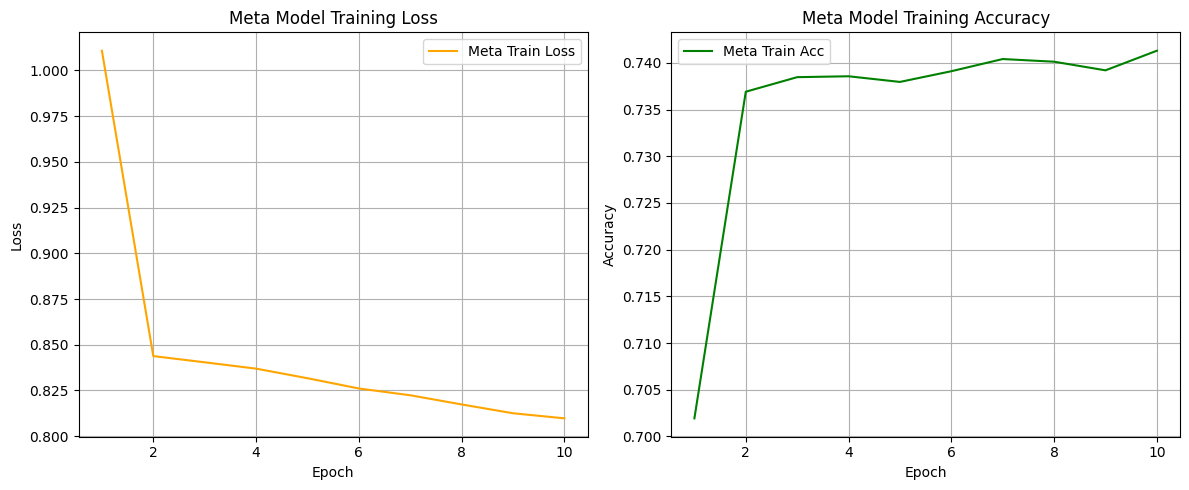

In [ ]:
# --- 训练 Meta Model ---

if glove_vectors:
    # 1. 重新获取数据集划分 (获取 Meta 训练集)
    full_ds_size = len(records)
    train_size = int(0.7 * full_ds_size)
    val_size = int(0.15 * full_ds_size)
    meta_size = full_ds_size - train_size - val_size

    _, _, meta_subset = random_split(
        range(full_ds_size), 
        [train_size, val_size, meta_size], 
        generator=torch.Generator().manual_seed(42)
    )
    meta_indices = meta_subset.indices

    print(f"Meta-training set size: {len(meta_indices)}")

    # 2. 加载已训练的基础模型 (GloVe 版)
    print("Loading base models for meta-training...")
    model_h, tok_h, label2id_h = load_base_model("../Results/glove/best_model_headline_glove.pt", device)
    model_d, tok_d, label2id_d = load_base_model("../Results/glove/best_model_description_glove.pt", device)

    assert label2id_h == label2id_d, "Label mappings do not match!"
    num_classes = len(label2id_h)
    
    # 3. 生成 Meta-Dataset
    X_meta, y_meta = generate_meta_dataset(records, meta_indices, model_h, tok_h, model_d, tok_d, label2id_h, device)

    # 4. 划分 Meta-Train / Meta-Val
    meta_dataset = torch.utils.data.TensorDataset(X_meta, y_meta)
    meta_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)
    
    # 5. 初始化 Meta Model
    meta_model = MetaClassifier(input_dim=num_classes * 2, hidden_dim=64, output_dim=num_classes).to(device)
    meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.001)
    meta_criterion = nn.CrossEntropyLoss()

    # 6. 训练循环
    print(f"\n{'='*20} 开始训练 Meta Model (权重融合) {'='*20}")
    start_time = time.time()

    num_meta_epochs = 10
    meta_history = {"loss": [], "acc": []}

    for epoch in range(1, num_meta_epochs + 1):
        meta_model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for features, labels in meta_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            meta_optimizer.zero_grad()
            logits = meta_model(features)
            loss = meta_criterion(logits, labels)
            loss.backward()
            meta_optimizer.step()
            
            total_loss += loss.item() * features.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
        avg_loss = total_loss / total
        acc = correct / total
        
        meta_history["loss"].append(avg_loss)
        meta_history["acc"].append(acc)
        
        if epoch % 2 == 0:
            print(f"Meta Epoch {epoch}/{num_meta_epochs}: loss={avg_loss:.4f}, acc={acc:.4f}")

    # 7. 保存 Meta Model
    torch.save(meta_model.state_dict(), "Results/glove/best_meta_model_glove.pt")
    print("已保存 Meta Model: Results/glove/best_meta_model_glove.pt")
    end_time = time.time()
    print(f"Meta Model 训练耗时: {end_time - start_time:.2f}s")

    # --- Meta Model 训练可视化 ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_meta_epochs + 1), meta_history["loss"], label="Meta Train Loss", color='orange')
    plt.title("Meta Model Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_meta_epochs + 1), meta_history["acc"], label="Meta Train Acc", color='green')
    plt.title("Meta Model Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Skipping Meta Model training.")


## 5.模型使用

In [8]:
import os
import torch.nn.functional as F
import numpy as np

class SingleModelPredictor:
    """单个模型的预测器封装"""
    def __init__(self, checkpoint_path, device):
        self.device = device
        self.model, self.tokenizer, self.id2label, self.config = self._load_model(checkpoint_path)
        
    def _load_model(self, checkpoint_path):
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Model file not found: {checkpoint_path}")
            
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        vocab = checkpoint["vocab"]
        label2id = checkpoint["label2id"]
        id2label = checkpoint["id2label"]
        cfg = checkpoint.get("config", {})

        tokenizer = WhitespaceTokenizer(
            max_vocab_size=len(vocab),
            min_freq=1,
            max_length=cfg.get("max_length", 64),
        )
        tokenizer.token_to_id = vocab
        tokenizer.id_to_token = {v: k for k, v in vocab.items()}

        model = NewsClassifier(
            vocab_size=len(tokenizer.token_to_id),
            num_labels=len(label2id),
            d_model=cfg.get("d_model", 100),
            num_heads=cfg.get("num_heads", 4),
            num_layers=cfg.get("num_layers", 2),
            dim_feedforward=cfg.get("dim_feedforward", 256),
            dropout=0.1,
            pretrained_embeddings=None # 推理时不需要加载 GloVe 原始文件，权重在 state_dict 里
        ).to(self.device)
        
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        return model, tokenizer, id2label, cfg

    def get_probs(self, text: str):
        """返回预测概率分布 (Softmax output)"""
        ids, attn = self.tokenizer.encode(text)
        input_ids = torch.tensor([ids], dtype=torch.long).to(self.device)
        attention_mask = torch.tensor([attn], dtype=torch.long).to(self.device)
        
        with torch.no_grad():
            logits = self.model(input_ids, attention_mask)
            probs = F.softmax(logits, dim=1) # 转换为概率
        return probs


class EnsemblePredictor:
    """集成预测器：结合标题模型和摘要模型的结果"""
    def __init__(self, headline_model_path="Results/glove/best_model_headline_glove.pt", desc_model_path="Results/glove/best_model_description_glove.pt", meta_model_path="Results/glove/best_meta_model_glove.pt", device=device):
        self.device = device
        self.headline_predictor = None
        self.desc_predictor = None
        self.meta_model = None
        
        # 1. 加载基础模型
        if os.path.exists(headline_model_path):
            print(f"Loading Headline Model from {headline_model_path}...")
            self.headline_predictor = SingleModelPredictor(headline_model_path, device)
        
        if os.path.exists(desc_model_path):
            print(f"Loading Description Model from {desc_model_path}...")
            self.desc_predictor = SingleModelPredictor(desc_model_path, device)
            
        # 2. 加载 Meta Model (权重模型)
        if os.path.exists(meta_model_path) and self.headline_predictor and self.desc_predictor:
            print(f"Loading Meta Model from {meta_model_path}...")
            num_classes = len(self.headline_predictor.id2label)
            # Meta Model 输入维度是两个基础模型类别数之和
            self.meta_model = MetaClassifier(input_dim=num_classes * 2, hidden_dim=64, output_dim=num_classes).to(device)
            self.meta_model.load_state_dict(torch.load(meta_model_path, map_location=device))
            self.meta_model.eval()
        else:
            print("Warning: Meta Model not loaded (or base models missing). Will use simple averaging if needed.")

        # 设置 id2label (假设两个模型标签一致)
        if self.headline_predictor:
            self.id2label = self.headline_predictor.id2label
        elif self.desc_predictor:
            self.id2label = self.desc_predictor.id2label
        else:
            raise RuntimeError("No models loaded! Please train models first.")

    def predict(self, headline: str = "", description: str = ""):
        """
        综合预测函数 (使用 Meta Model 进行融合)
        """
        probs_h = None
        probs_d = None
        
        # 1. 获取基础模型预测
        if headline and self.headline_predictor:
            probs_h = self.headline_predictor.get_probs(headline)
            
        if description and self.desc_predictor:
            probs_d = self.desc_predictor.get_probs(description)
            
        # 2. 综合决策逻辑
        if probs_h is not None and probs_d is not None:
            # Case 3: 两者都有 -> 使用 Meta Model 融合
            if self.meta_model:
                # 拼接特征: [probs_h, probs_d]
                meta_input = torch.cat([probs_h, probs_d], dim=1)
                with torch.no_grad():
                    final_logits = self.meta_model(meta_input)
                    final_probs = F.softmax(final_logits, dim=1)
                # print("Mode: Ensemble (Meta Model)")
            else:
                # Fallback: 简单平均 (如果没有训练 Meta Model)
                final_probs = 0.6 * probs_h + 0.4 * probs_d
                # print("Mode: Ensemble (Simple Average)")
                
        elif probs_h is not None:
            # Case 1: 只有标题 (例如摘要缺失)
            final_probs = probs_h
            # print("Mode: Headline Only")
        elif probs_d is not None:
            # Case 2: 只有摘要 (例如标题缺失)
            final_probs = probs_d
            # print("Mode: Description Only")
        else:
            return "Unknown"
            
        # 获取最大概率对应的类别
        pred_idx = torch.argmax(final_probs, dim=1).item()
        return self.id2label[pred_idx]

# --- 示例运行 ---
try:
    ensemble = EnsemblePredictor()
    
    test_cases = [
        {
            "headline": "NASA announces new moon mission", 
            "desc": "The space agency revealed plans for the Artemis program to return humans to the lunar surface."
        },
        {
            "headline": "Stocks surge as tech leads the rally", 
            "desc": "" # 缺失摘要
        },
        {
            "headline": "", # 缺失标题
            "desc": "A new study published in Nature shows that daily meditation can reduce stress levels significantly."
        }
    ]
    
    print("\n--- Inference Results ---")
    for case in test_cases:
        h = case["headline"]
        d = case["desc"]
        pred = ensemble.predict(headline=h, description=d)
        print(f"Headline: {h[:30]}... | Desc: {d[:30]}... -> Prediction: {pred}")
        
except Exception as e:
    print(f"Error during inference: {e}")
    # import traceback
    # traceback.print_exc()
    print("请确保已运行上方的训练单元并生成了 .pt 模型文件。")

Loading Headline Model from Results/glove/best_model_headline_glove.pt...
Loading Description Model from Results/glove/best_model_description_glove.pt...
Loading Meta Model from Results/glove/best_meta_model_glove.pt...

--- Inference Results ---
Headline: NASA announces new moon missio... | Desc: The space agency revealed plan... -> Prediction: Science, Tech & Environment
Headline: Stocks surge as tech leads the... | Desc: ... -> Prediction: Science, Tech & Environment
Headline: ... | Desc: A new study published in Natur... -> Prediction: Health & Wellness
